In [1]:
import cv2
import pandas as pd
import numpy as np
from skimage import io
import sys  
cv2.__version__

'4.5.5'

In [2]:
import os, random
#normalization open cv
random_face_group = []
num_picks = 2000
for i in range(num_picks):
    face_str = random.choice(os.listdir('UTKFace'))
    face_str_split = face_str.split('_')
    if(face_str_split[1]=='0'):
        gender = 'male'
    else:
        gender = 'female'
    
    #set race
    if face_str_split[2]=='0':
        race='white'
    elif face_str_split[2]=='1':
        race = 'black'
    elif face_str_split[2]=='2':
        race='asian'
    elif face_str_split[2]=='3':
        race='indian'
    else:
        race='other'
    face_dict = {'gender':gender,'race':race,'path':face_str}
    random_face_group.append(face_dict)

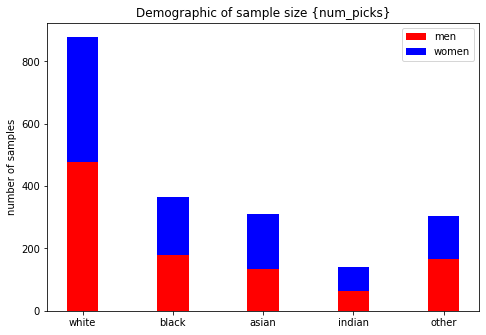

In [3]:
import matplotlib.pyplot as plt

##0: white, 1: black, 2: Asian, 3: Indian, 4: other
men = [0,0,0,0,0]
women = [0,0,0,0,0]
racial_categories = ['white','black','asian','indian','other']

for person in random_face_group:
    race_val = 4
    if person['race']==racial_categories[0]:
        race_val = 0
    elif person['race']==racial_categories[1]:
        race_val = 1
    elif person['race']==racial_categories[2]:
        race_val = 2
    elif person['race']==racial_categories[4]:
        race_val = 3
    
    if person['gender']=='female':
        women[race_val]+=1
    elif person['gender']=='male':
        men[race_val]+=1

num_races = len(racial_categories)
width = 0.35

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ind = np.arange(num_races)

ax.bar(ind,men,width, color='r')
ax.bar(ind,women,width,bottom=men,color='b')
ax.set_ylabel("number of samples")
title = 'Demographic of sample size {num_picks}'
ax.set_title(title)
ax.set_xticks(ind,racial_categories)
ax.legend(['men','women'])

plt.show()

In [4]:
from matplotlib import image
face_df = pd.DataFrame.from_dict(random_face_group)

img_data = {x:0 for x in range(len(face_df))}
for idx, row in face_df.iterrows():
    relative_path = 'UTKFace\\'+str(row["path"])
    img = image.imread(relative_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_data[idx] = gray


face_df['img_data'] = pd.Series(img_data)
face_df


,gender,race,path,img_data
0,female,white,16_1_0_20170109213604149.jpg.chip.jpg,"[[91, 91, 98, 96, 119, 153, 171, 201, 205, 208..."
1,female,asian,24_1_2_20170116173716204.jpg.chip.jpg,"[[73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, ..."
2,male,indian,57_0_3_20170119183926056.jpg.chip.jpg,"[[127, 128, 129, 131, 132, 134, 135, 136, 139,..."
3,male,white,56_0_0_20170104210832380.jpg.chip.jpg,"[[32, 33, 31, 23, 17, 21, 34, 48, 55, 50, 42, ..."
4,male,indian,6_0_3_20170110213739717.jpg.chip.jpg,"[[67, 66, 58, 45, 37, 41, 48, 53, 62, 65, 55, ..."
...,...,...,...,...
1995,male,indian,45_0_3_20170120222425936.jpg.chip.jpg,"[[1, 1, 1, 2, 2, 3, 3, 3, 3, 4, 6, 8, 12, 23, ..."
1996,male,other,48_0_4_20170104211610652.jpg.chip.jpg,"[[86, 87, 89, 90, 91, 90, 89, 88, 84, 78, 69, ..."
1997,female,black,26_1_1_20170117153641469.jpg.chip.jpg,"[[46, 49, 51, 54, 56, 59, 63, 66, 70, 73, 80, ..."
1998,male,indian,4_0_3_20161220220741730.jpg.chip.jpg,"[[65, 61, 53, 42, 32, 28, 31, 34, 22, 23, 24, ..."


In [6]:
from sklearn.decomposition import PCA

def get_eigenface(sample_idx, x, max_coef=10):
    """ plots estimates of original image from pca compression
    
    Args:
        sample_idx (int): which image to work with
        x (np.array): (n_sample, n_feat) original image data
        max_coef (int): maximum pca coefficient to represent
    """
    
    
    # the default n_components will have PCA build as 
    # many compnents as there are features.  this is preferred
    # here as we can use our limit_coef param as needed
    pca = PCA()

    # compress all faces to lower dimensional representation
    face_data_compress = pca.fit_transform(face_data)
    
    for limit_coef in range(max_coef):
        # estimate original image
        x_compress = face_data_compress[sample_idx, :]
        x_pred = inverse_transform(x_compress, pca, limit_coef=limit_coef)
        
        # compute compression ratio stats
        n_compress = limit_coef + 1
        n = x_pred.size
        p = n_compress / n
        
        # plot this estimate
        plt.figure()
        plot_face(x_pred)
        title = f'{n_compress} of {n} features ({p:.3f} of memory)'
        plt.suptitle(title)